In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/store-sales-time-series-forecasting/oil.csv
/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv
/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv
/kaggle/input/store-sales-time-series-forecasting/stores.csv
/kaggle/input/store-sales-time-series-forecasting/train.csv
/kaggle/input/store-sales-time-series-forecasting/test.csv
/kaggle/input/store-sales-time-series-forecasting/transactions.csv


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import warnings
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller


train_data = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/train.csv')
test_data = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/test.csv')
oil_data = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/oil.csv')
transactions_data = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/transactions.csv')
holidays_data = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv')
stores_data = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/stores.csv')

train_data

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0
1,1,2013-01-01,1,BABY CARE,0.000,0
2,2,2013-01-01,1,BEAUTY,0.000,0
3,3,2013-01-01,1,BEVERAGES,0.000,0
4,4,2013-01-01,1,BOOKS,0.000,0
...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.133,0
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8


In [3]:
def plot_df(df, x, y):
    f, ax = plt.subplots(figsize=(16,9))
    sns.lineplot(data = df, x=x, y=y)
    plt.tight_layout()
    plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


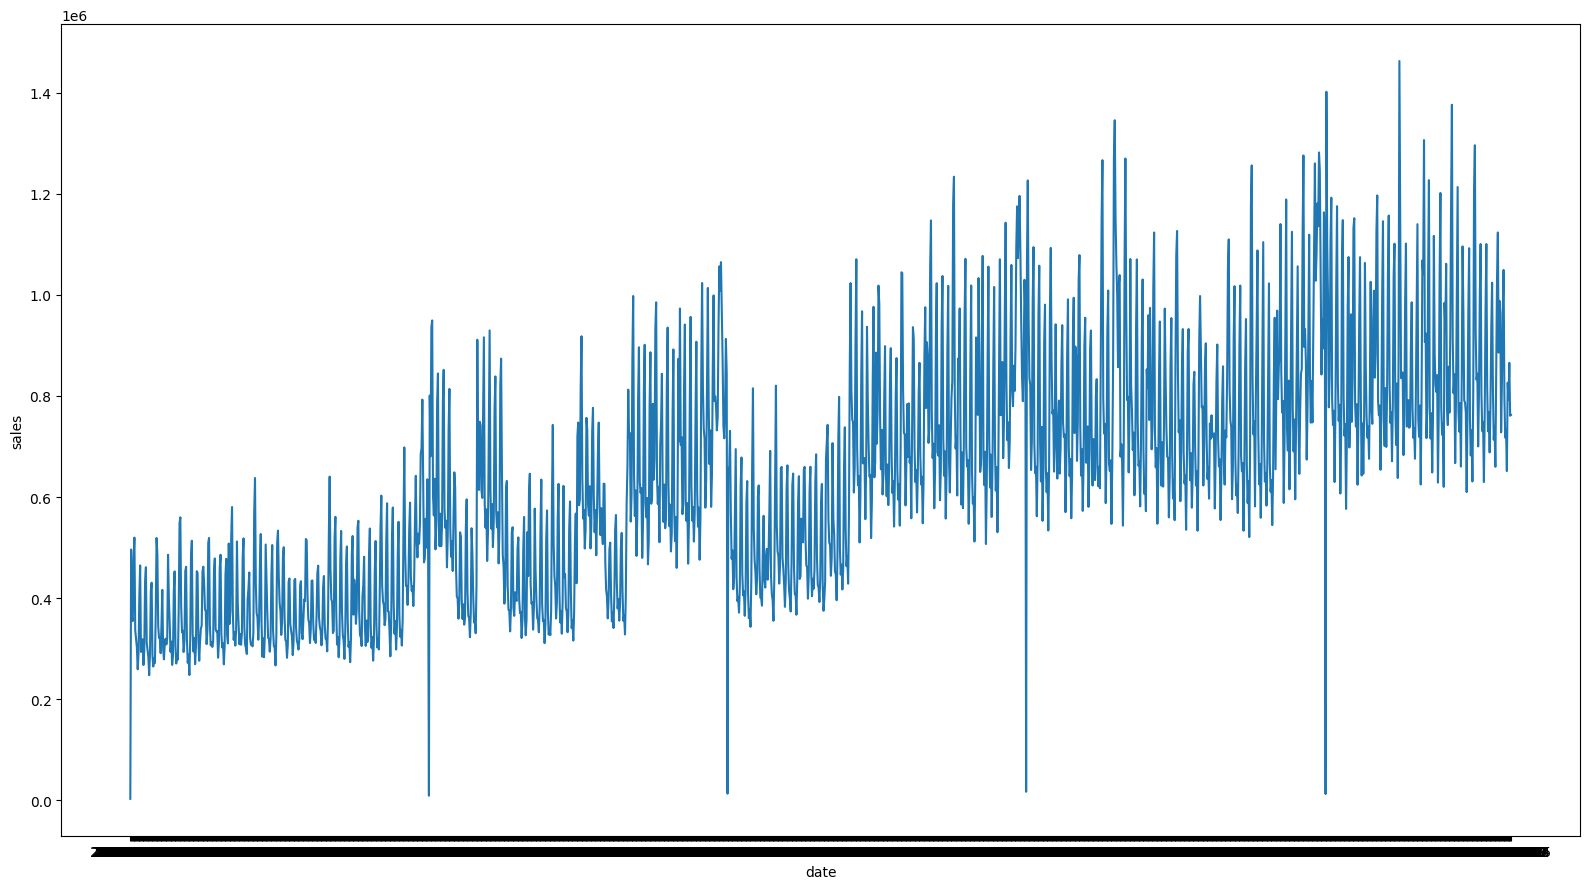

In [4]:
#plot total sales by day
plot_df(train_data.groupby('date')['sales'].sum().reset_index(), x='date', y='sales')

#### Clearly, there is some seasonality in the data

#### Lets use the Augmented Dicky Fuller Test to show this

In [ ]:

results = adfuller(train_data.groupby('date')['sales'].sum())
results

(-2.616195748604858,
 0.08969592175787444,
 22,
 1661,
 {'1%': -3.4342930672797065,
  '5%': -2.8632816397229064,
  '10%': -2.567697207194407},
 42848.480392783786)

#### We see a p_value of ~0.089. Thus, we fail to reject the null hypothesis, and cannot conclude that the data is stationary



#### Since the data is not stationary, let's attempt to make the data stationary

In [6]:
data = train_data.groupby('date')['sales'].sum()

/tmp/ipykernel_47/3053269084.py:10: UserWarning: The figure layout has changed to tight
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])
/tmp/ipykernel_47/3053269084.py:13: UserWarning: The figure layout has changed to tight
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])


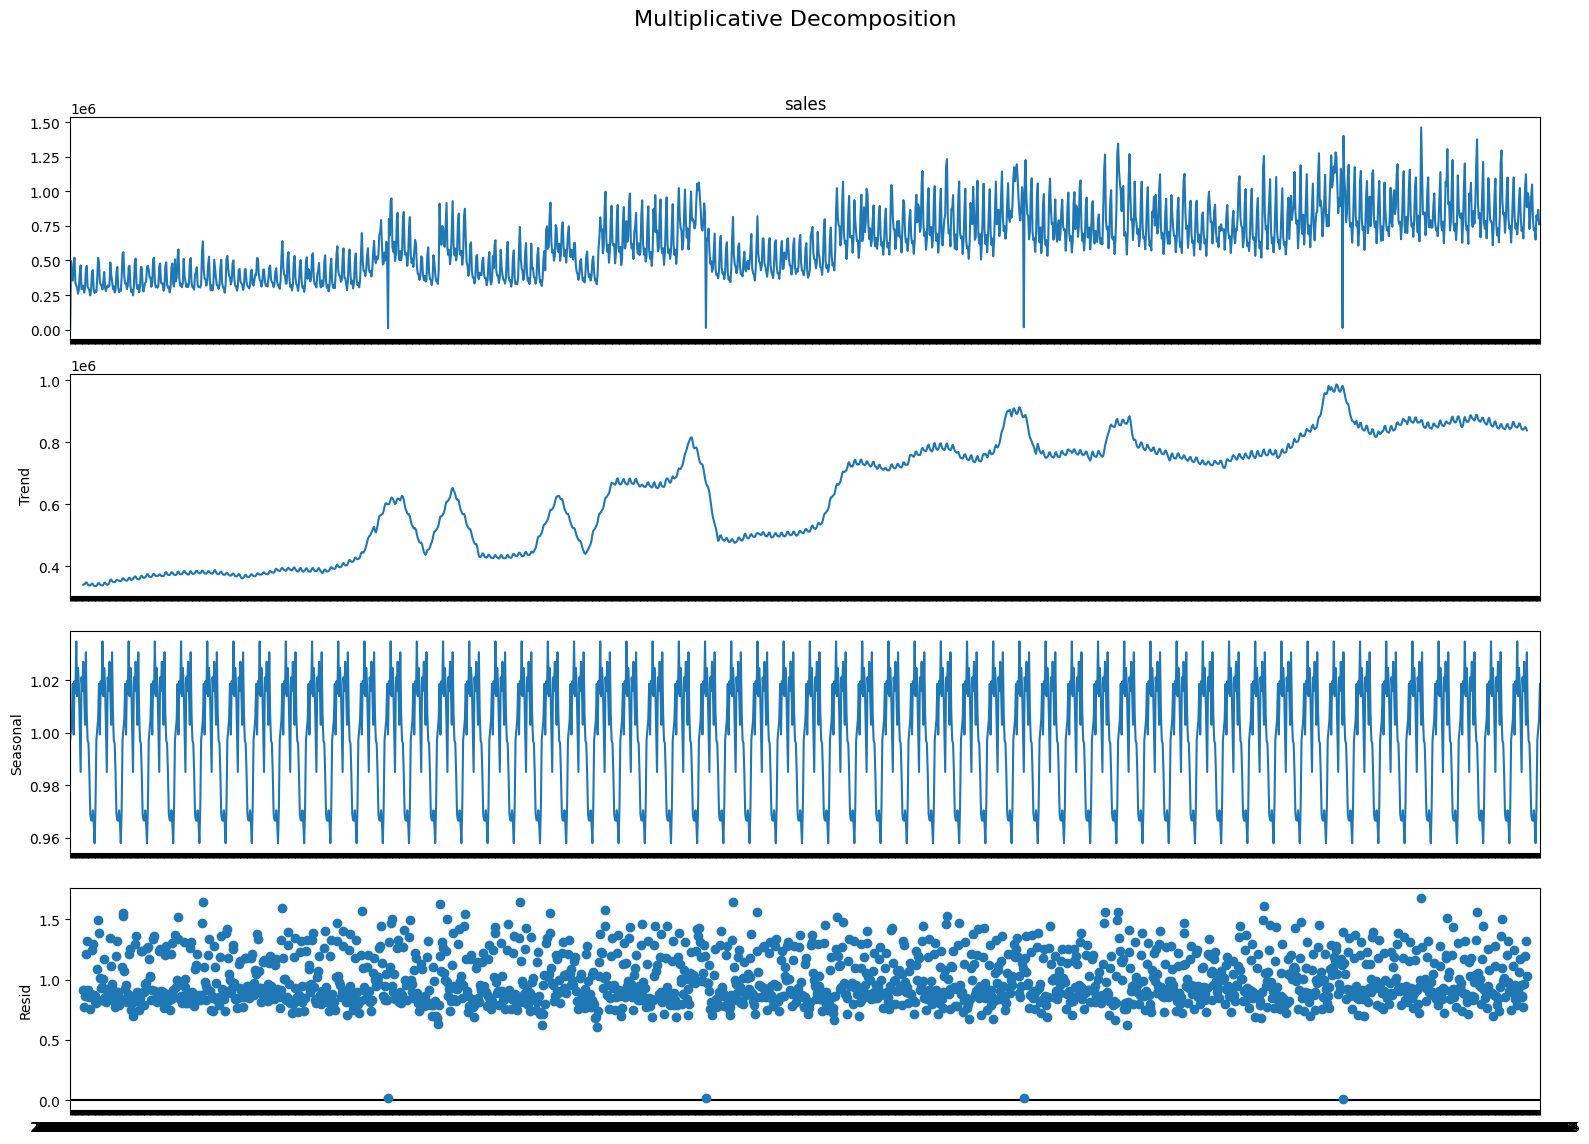

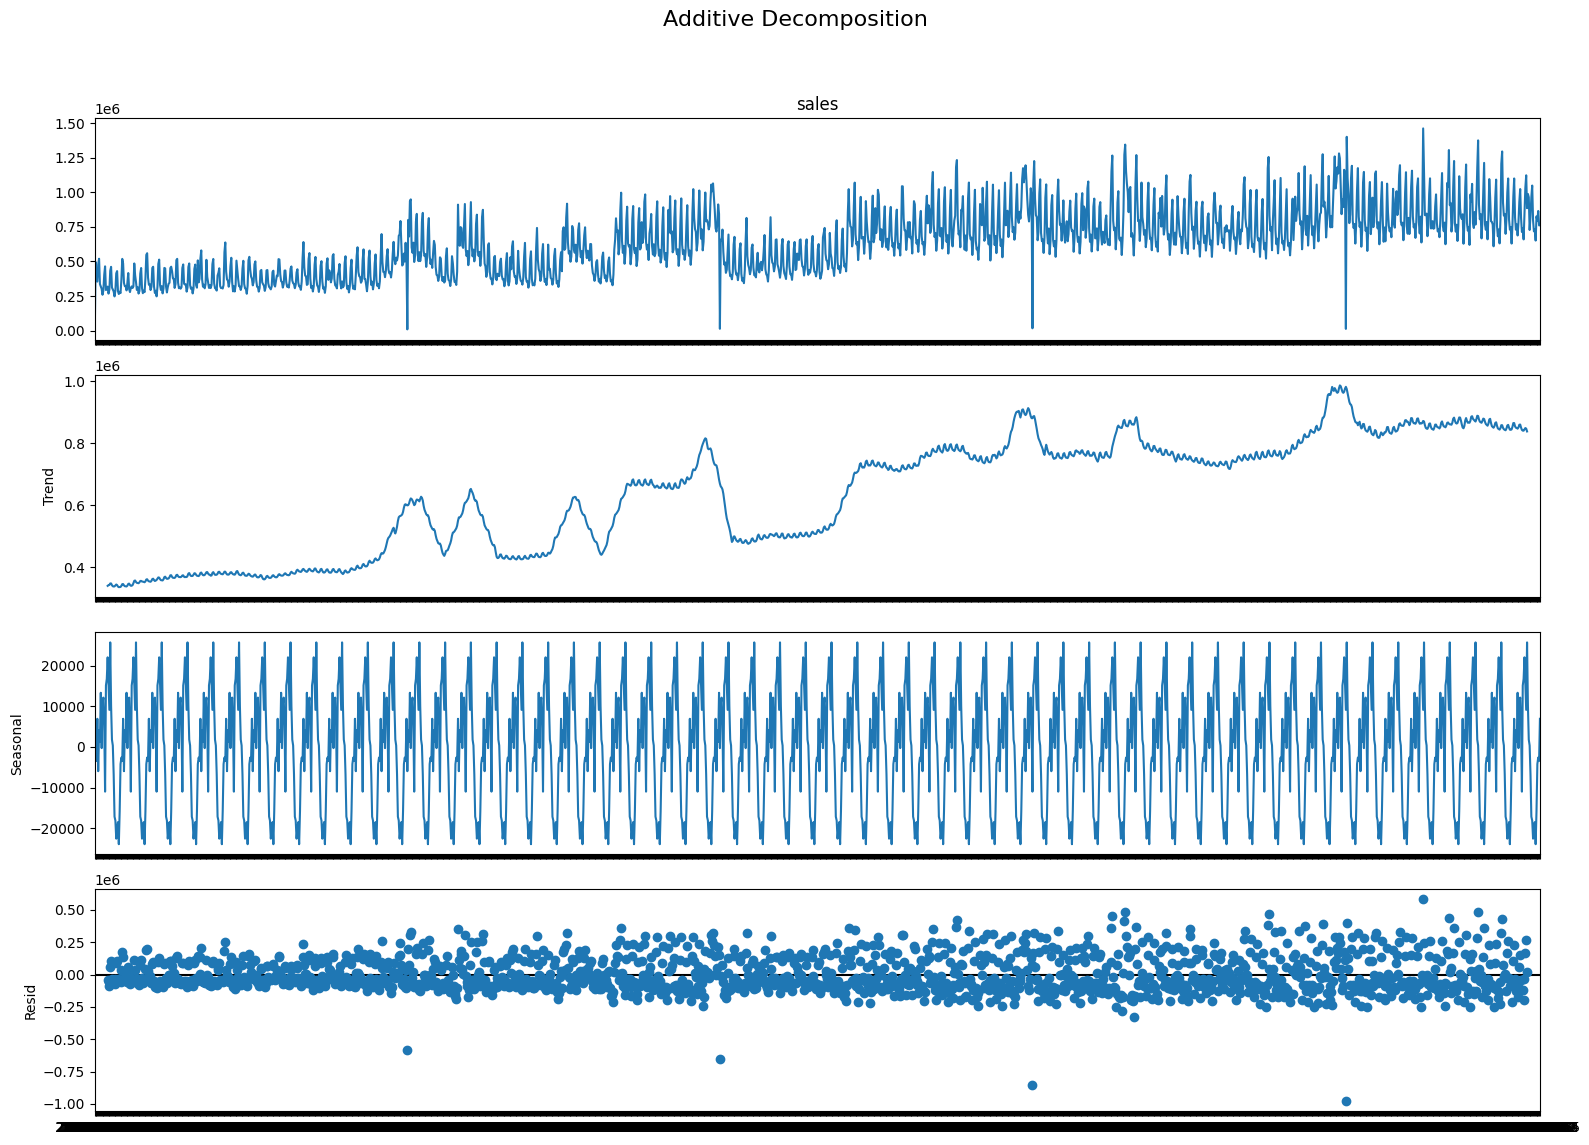

In [ ]:


multiplicative_decompose = seasonal_decompose(data, model='multiplicative', period=30)

additive_decompose = seasonal_decompose(data, model='additive', period=30)

plt.rcParams.update({'figure.figsize': (16,12)})
multiplicative_decompose.plot().suptitle('Multiplicative Decomposition', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

additive_decompose.plot().suptitle('Additive Decomposition', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

#### Residuals in the multiplicative decomposition seem to be more random than residuals in the additive decomposition, which seem to still have some of the pattern left over

#### Ideally, multiplicative decomposition seems to be more suitable for this time series



#### Lets attempt to make the time series stationary via differencing

In [ ]:

def plot_differences(data, period):
    stl = STL(data, period=period)
    res = stl.fit()
    trend = res.trend
    seasonal = res.seasonal
    residual = res.resid
    plt.figure(figsize=(15, 10))
    plt.subplot(3, 1, 1)
    trend.plot(title='Trend', color='blue')
    plt.subplot(3, 1, 2)
    seasonal.plot(title='Seasonal', color='green')
    plt.subplot(3, 1, 3)
    residual.plot(title='Residual', color='red')
    plt.tight_layout()
    plt.show()
    result = adfuller(residual.dropna())
    print(f"ADF Test on Residuals over a period of {period} days:")
    print(f"p-value:{result[1]}")

#### Observe the residuals and whether they are stationary or not to see if we can get identify all seasonal components. 

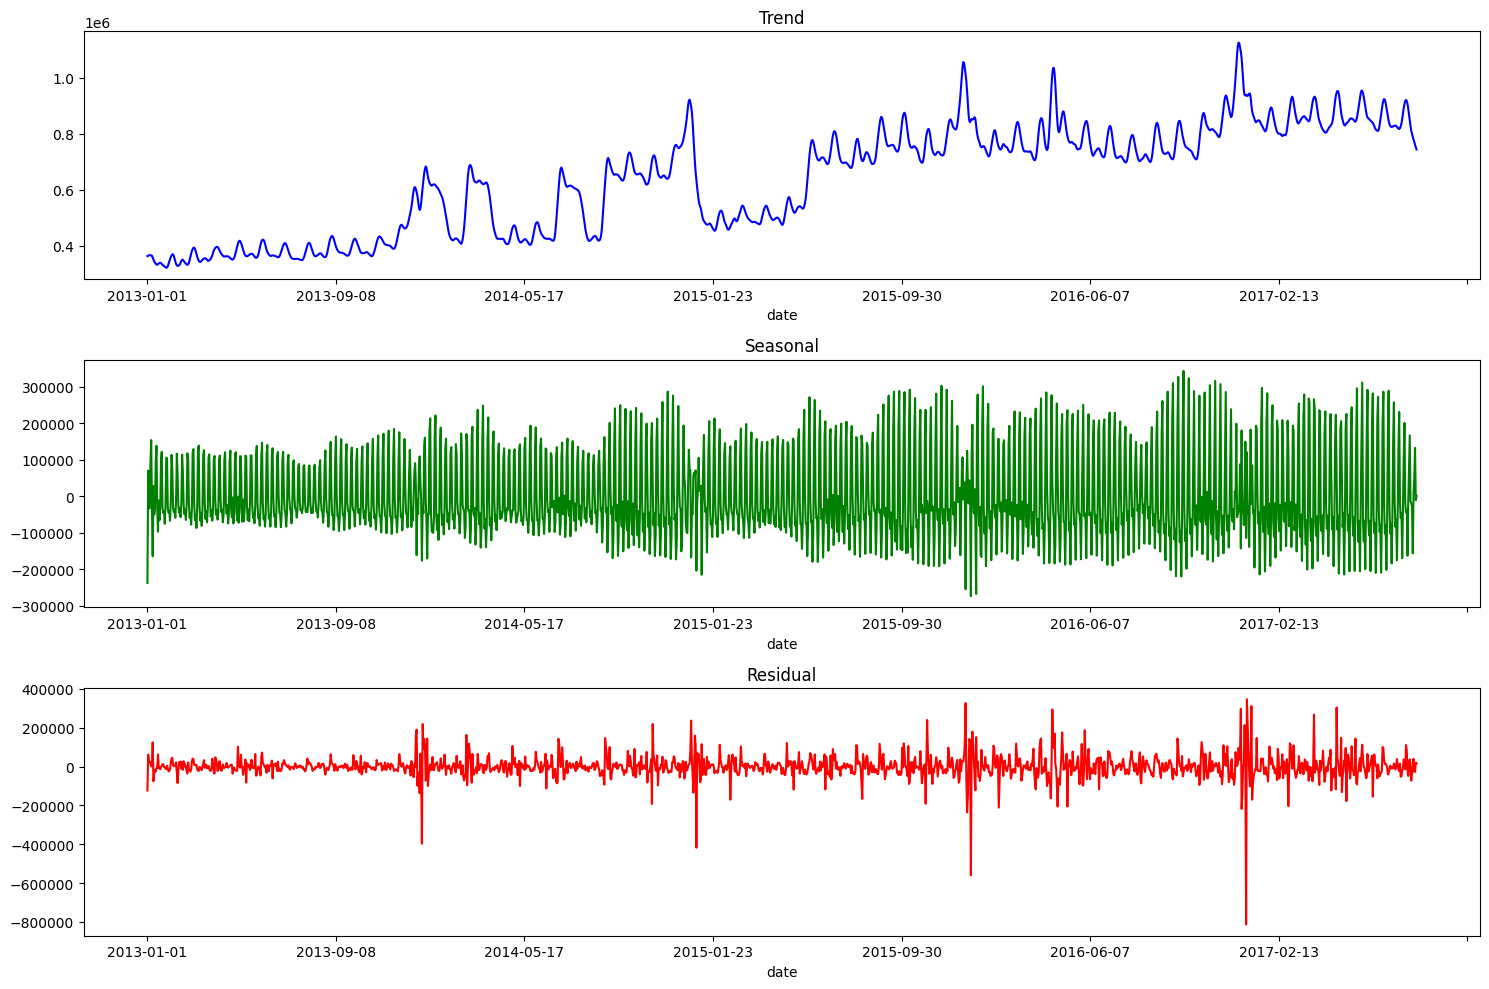

ADF Test on Residuals over a period of 7 days:
p-value:7.01769430658035e-27


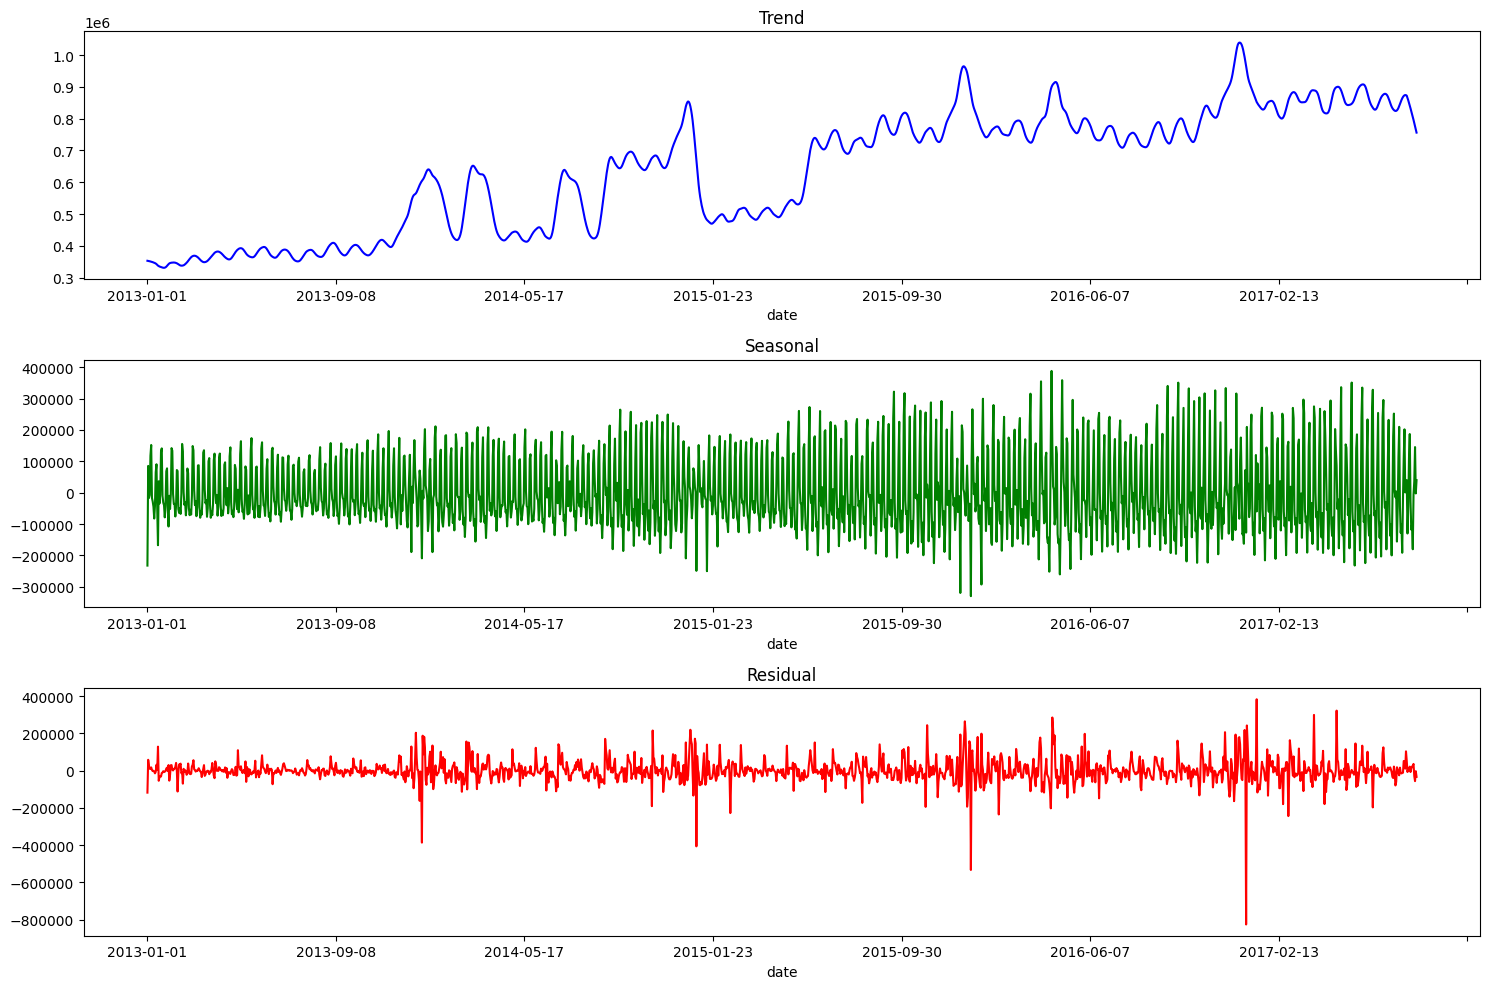

ADF Test on Residuals over a period of 14 days:
p-value:1.2782060474064922e-24


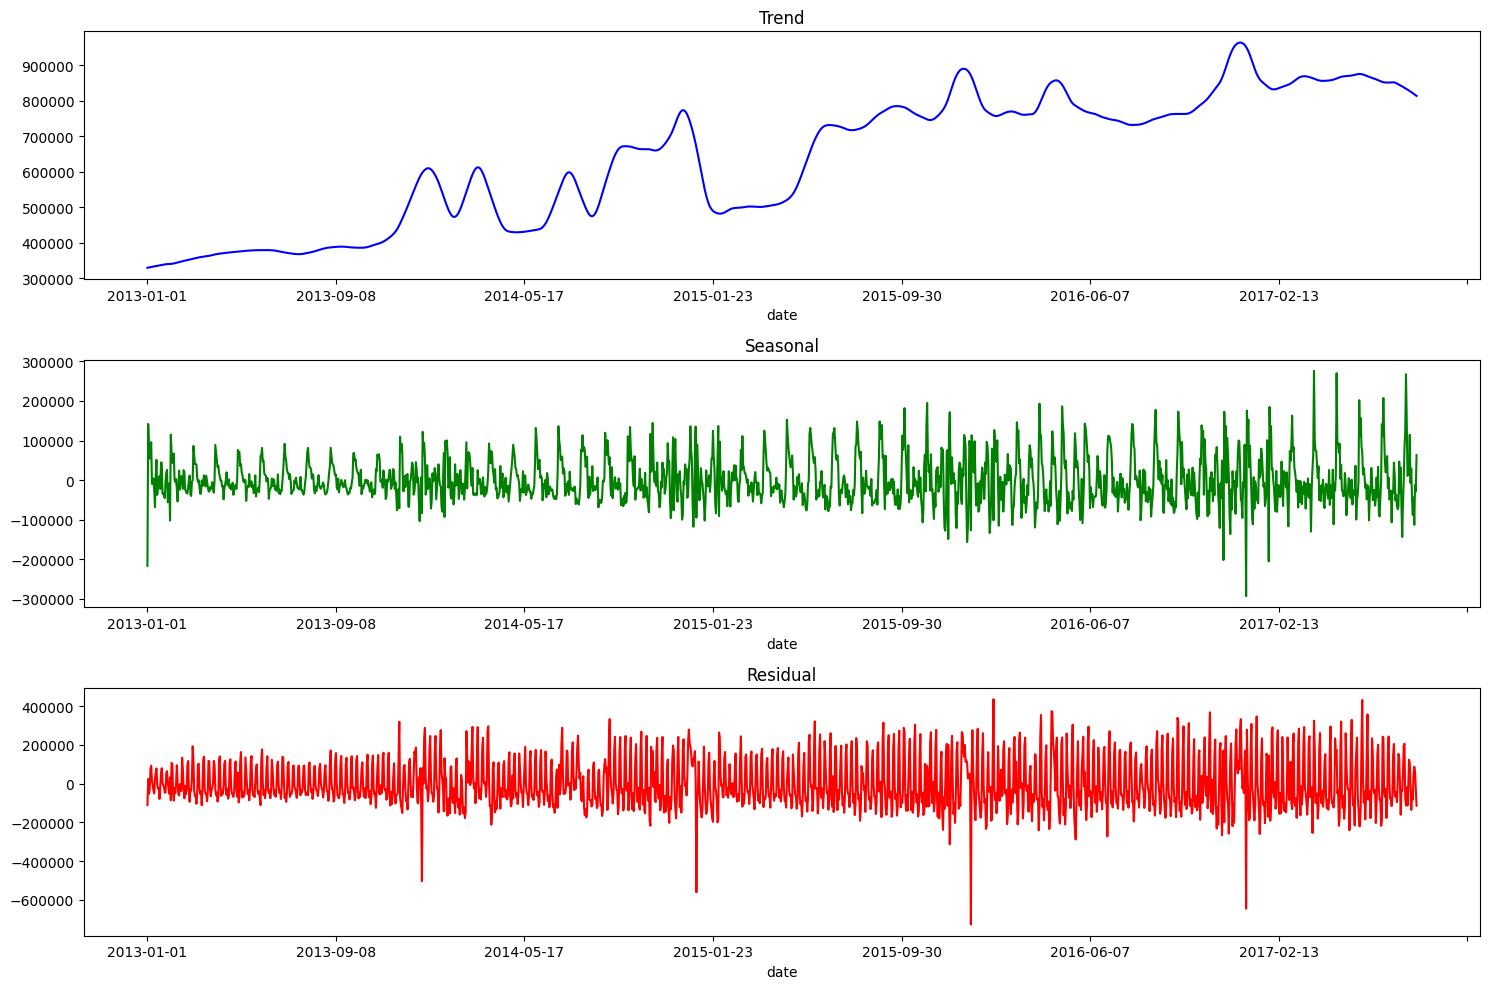

ADF Test on Residuals over a period of 30 days:
p-value:1.6532511053275576e-17


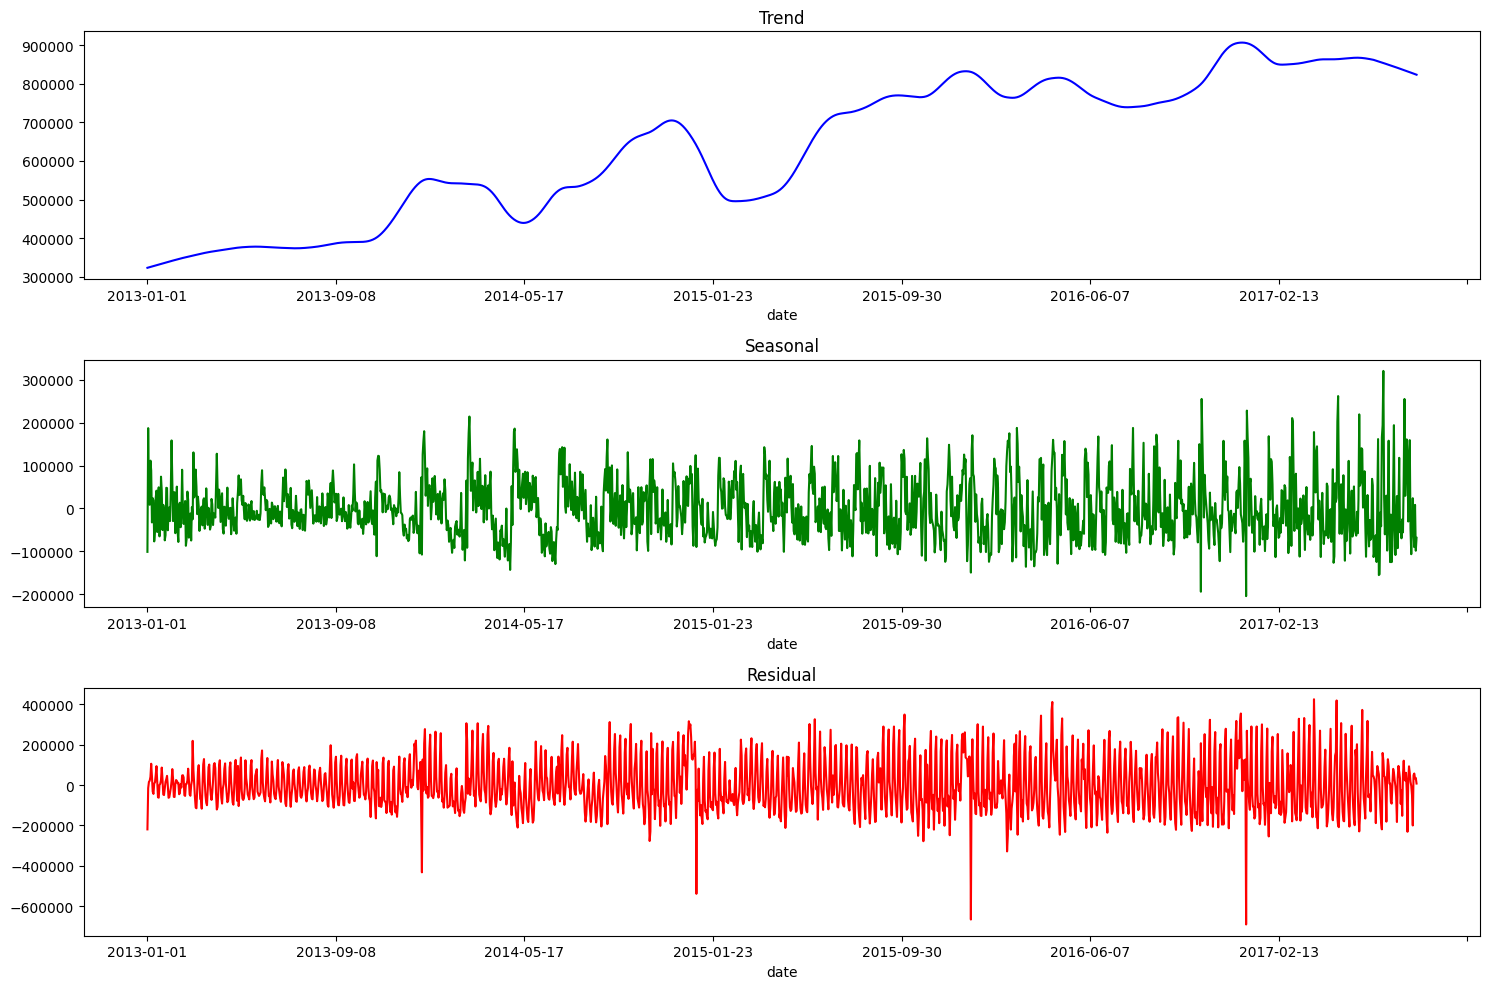

ADF Test on Residuals over a period of 60 days:
p-value:8.260587175083788e-15


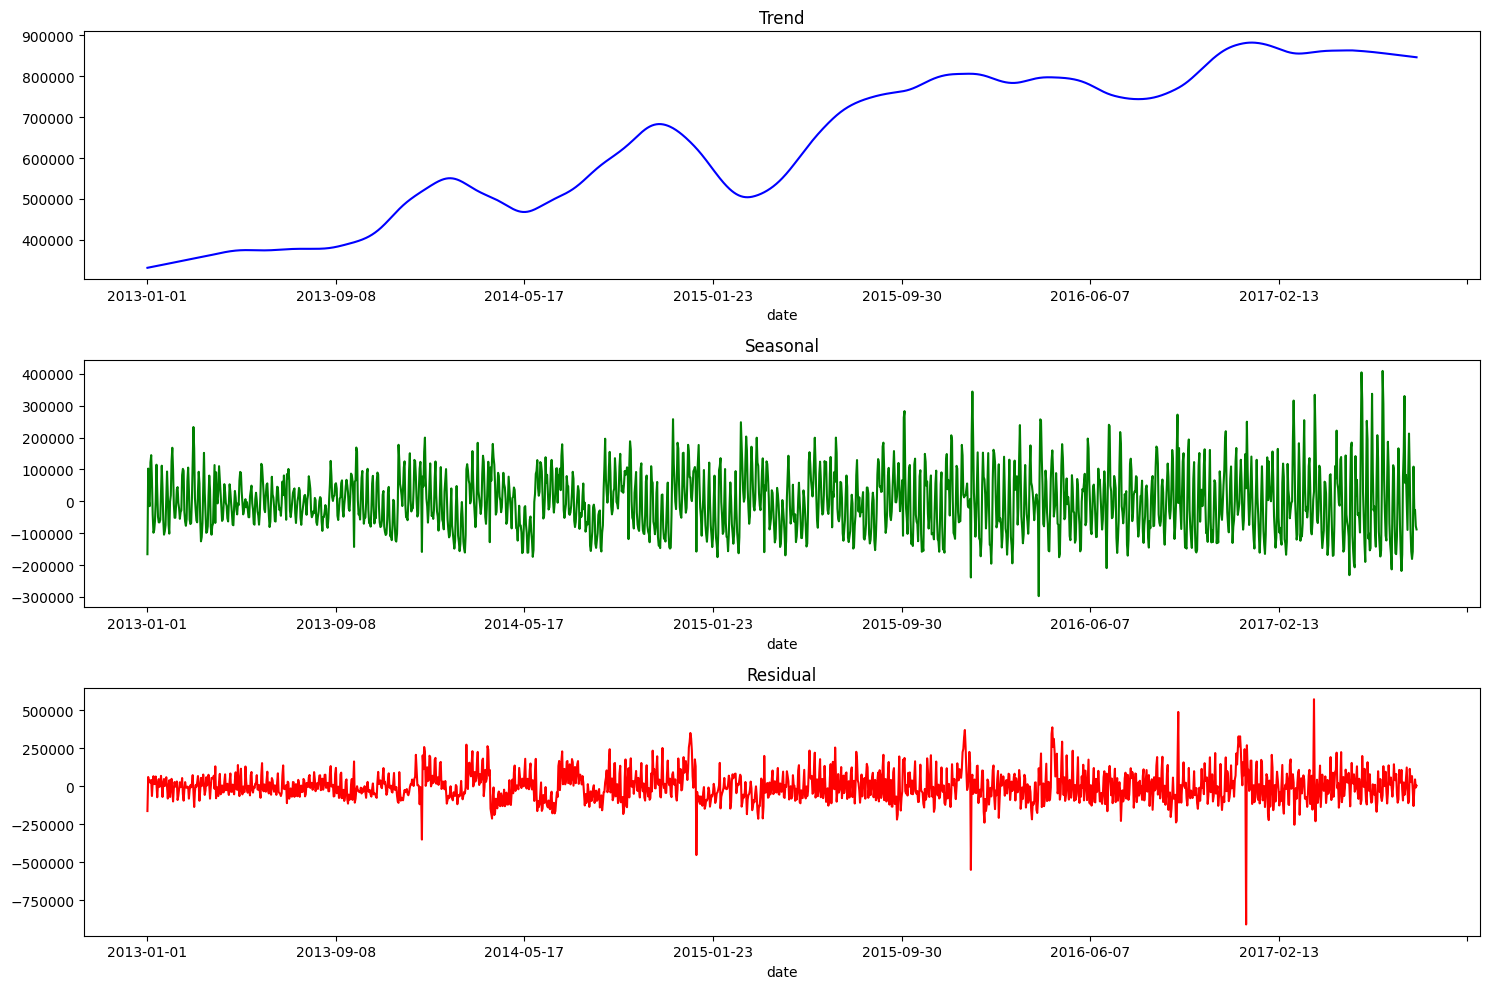

ADF Test on Residuals over a period of 90 days:
p-value:8.208191723408717e-17


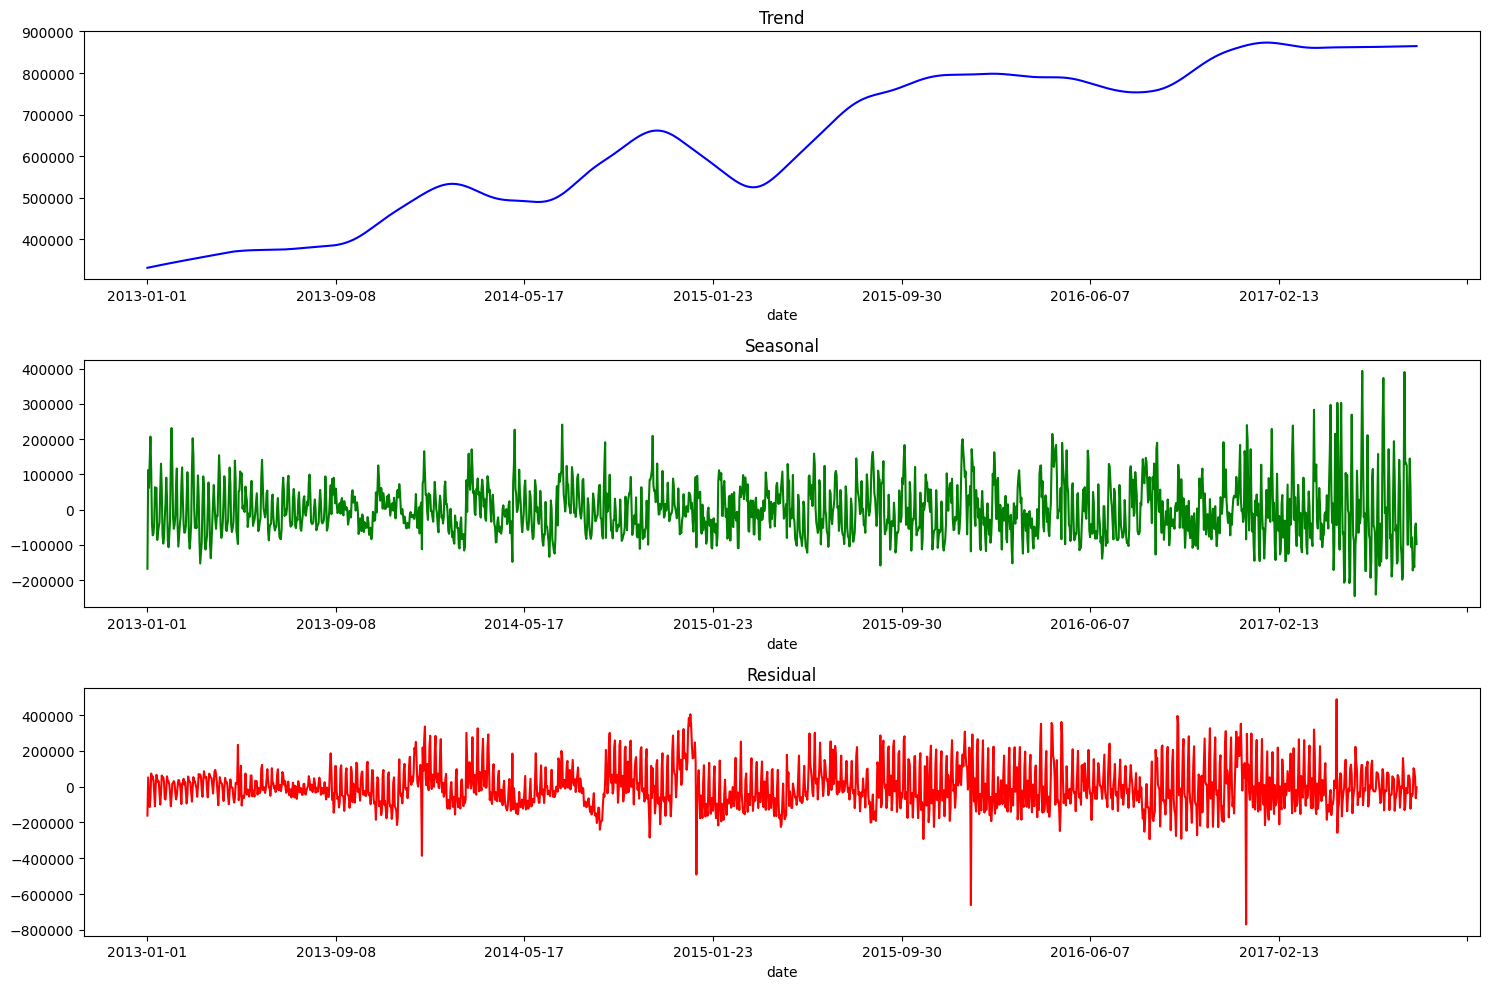

ADF Test on Residuals over a period of 120 days:
p-value:8.839271832125649e-13


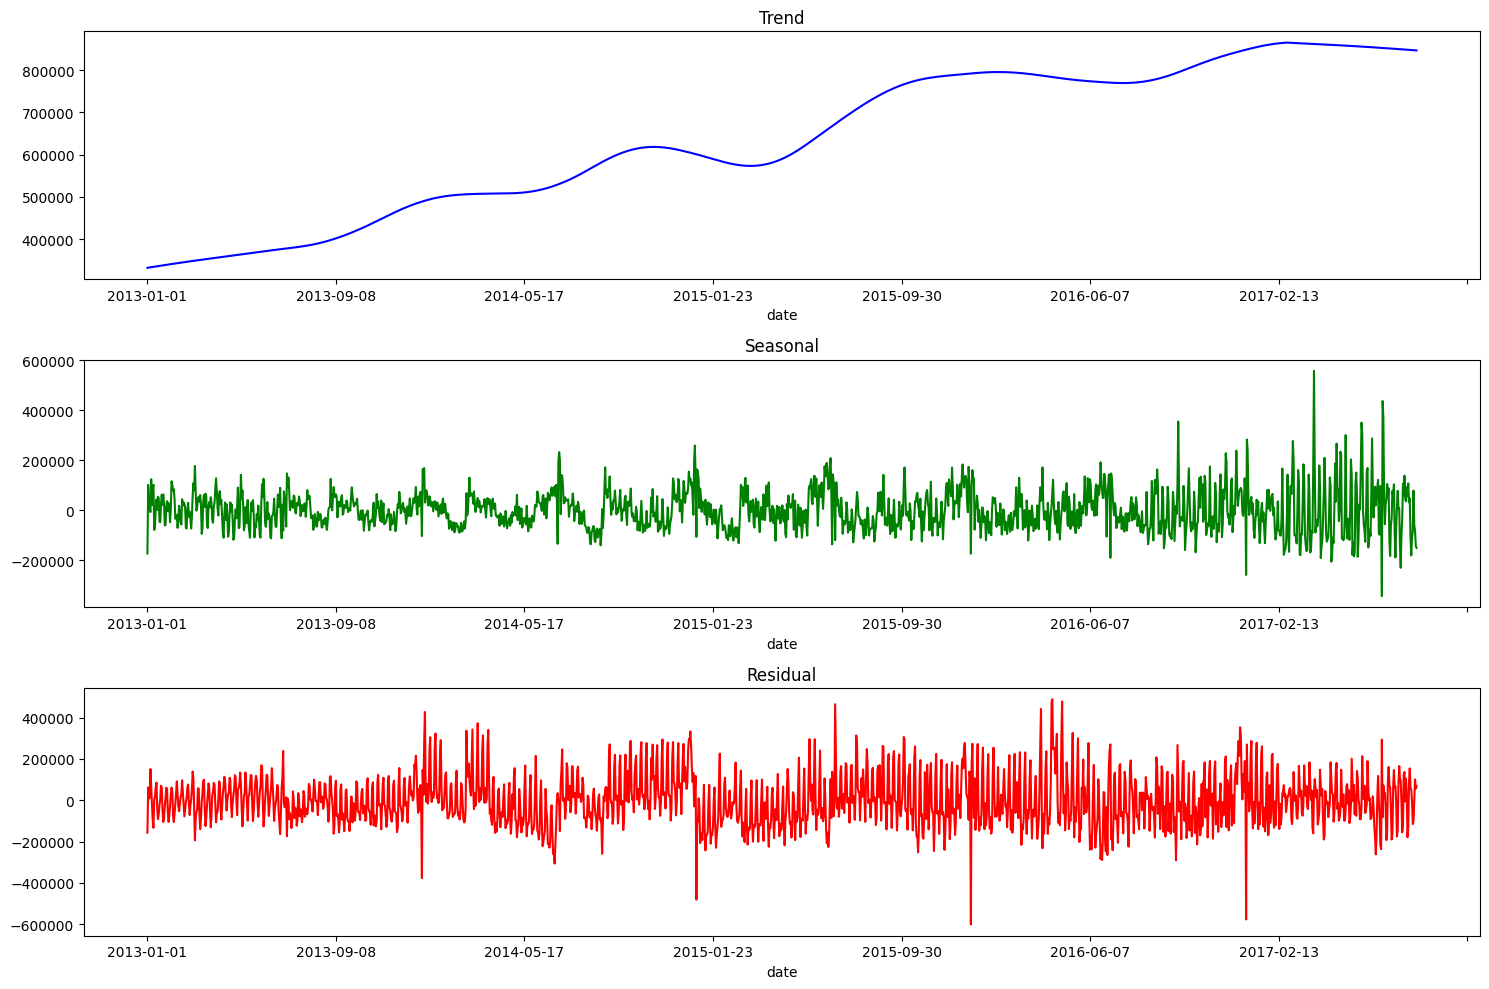

ADF Test on Residuals over a period of 180 days:
p-value:2.158640096124428e-09


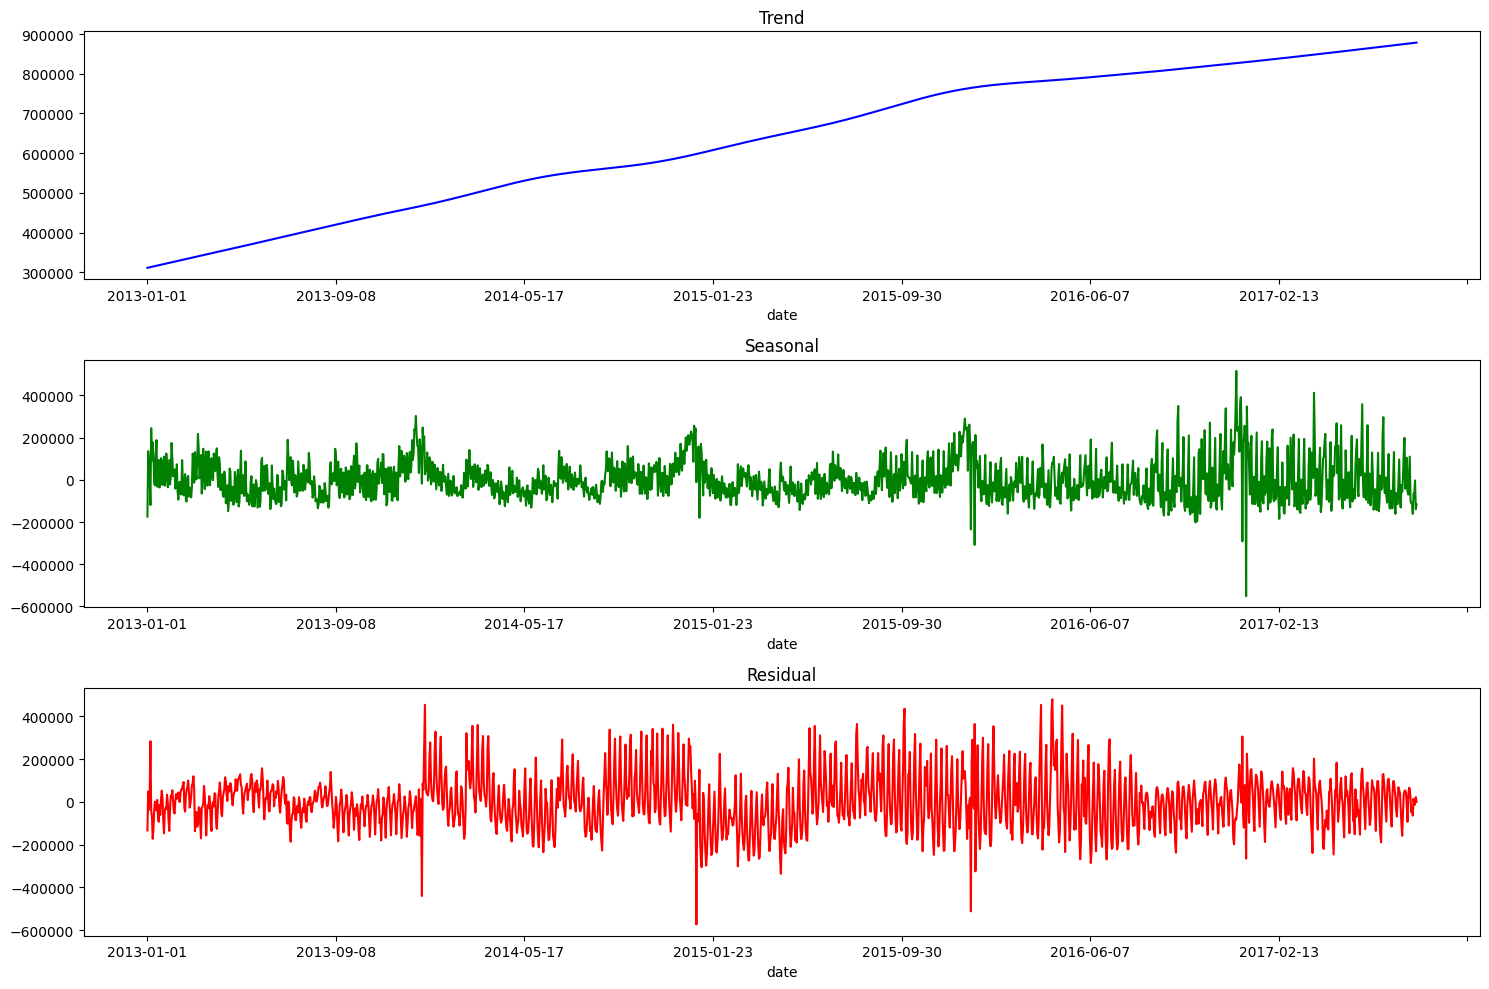

ADF Test on Residuals over a period of 360 days:
p-value:3.5267982789087525e-08


In [9]:
plot_differences(data, 7)
plot_differences(data, 14)
plot_differences(data, 30)
plot_differences(data, 60)
plot_differences(data, 90)
plot_differences(data, 120)
plot_differences(data, 180)
plot_differences(data, 360)

#### All p-values of the residuals are < 0.05, which suggests that all of the residuals are stationary for periods 7,14,30,60,90,120,180,365

### Autocorrelation and Partial Autocorrelation Plots

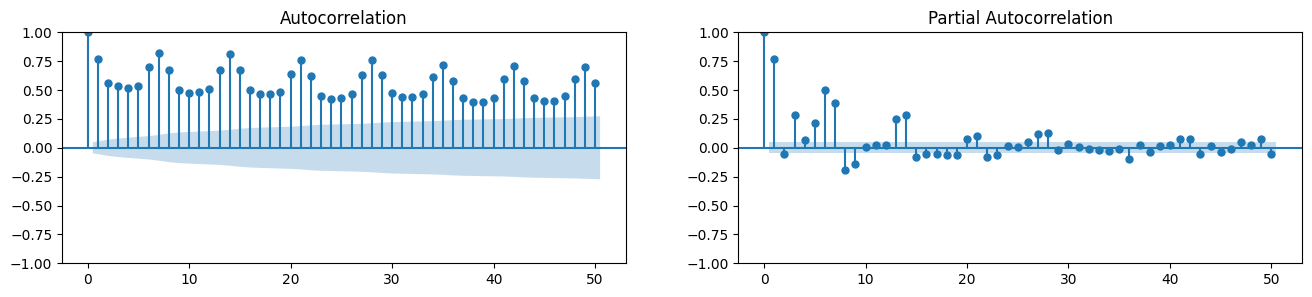

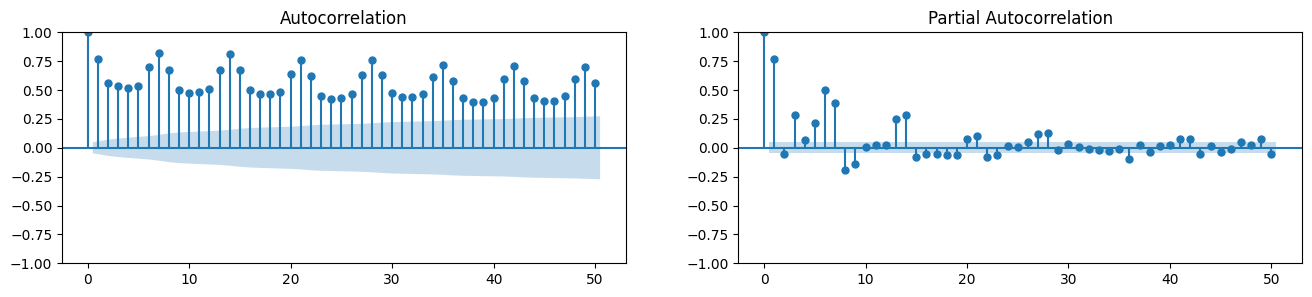

In [ ]:

fig, axes = plt.subplots(1,2,figsize=(16,3), dpi=100)
plot_acf(data.tolist(), lags=50, ax=axes[0])
plot_pacf(data.tolist(), lags=50, ax=axes[1])

### Lagplots

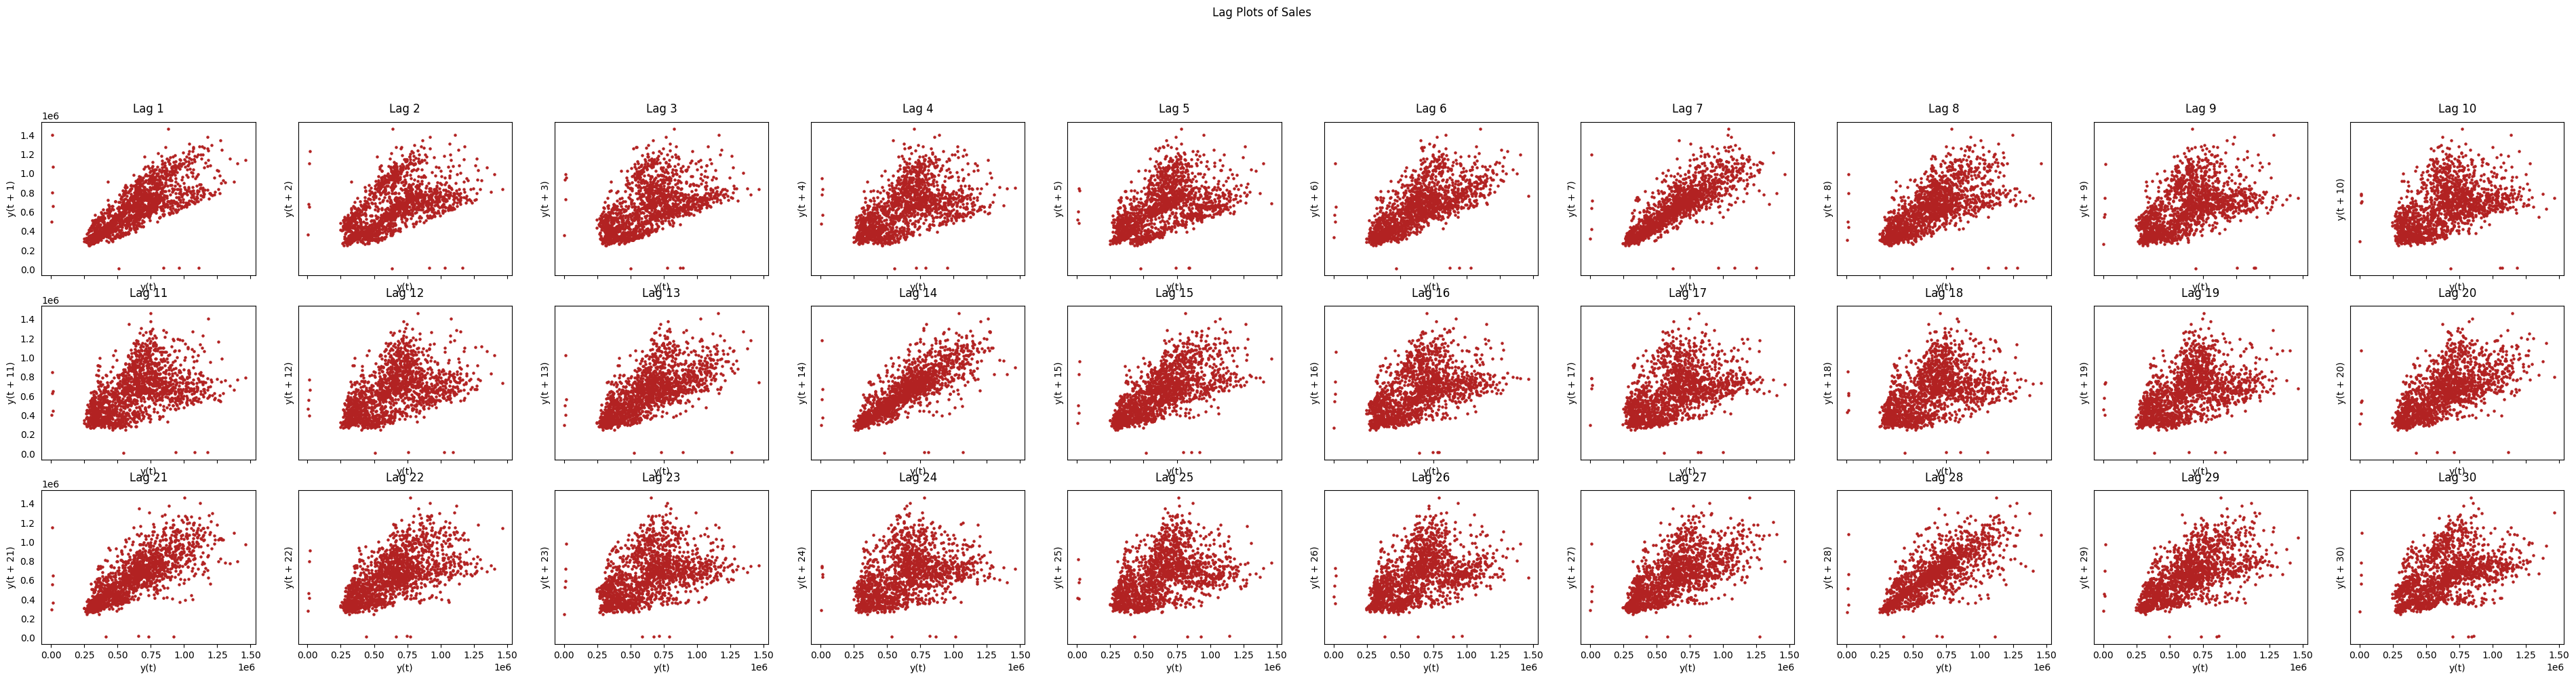

In [11]:
from pandas.plotting import lag_plot
import matplotlib.pyplot as plt

plt.rcParams.update({'ytick.left': False, 'axes.titlepad': 10})

fig, axes = plt.subplots(3, 10, figsize=(48, 10), sharex=True, sharey=True, dpi=100)

for i, ax in enumerate(axes.flatten()):
    lag_plot(data, lag=i+1, ax=ax, c='firebrick',s=5)
    ax.set_title(f'Lag {i+1}')

fig.suptitle('Lag Plots of Sales', y=1.05)    
plt.show()

#### We see points are tighter at lags 1, 7, 14, 28 compared to the rest of the lags

### Let's now create the features, we are going to be considering the oil data features, holiday data features and lag features

In [14]:
def rmsle(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_pred = np.clip(y_pred, 0, None)
    return np.sqrt(np.mean((np.log1p(y_pred) - np.log1p(y_true))**2))

for df in [train_data, test_data, oil_data, transactions_data, holidays_data, stores_data]:
    if "date" in df.columns:
        df["date"] = pd.to_datetime(df["date"])

# add oil data
oil_data = oil_data.sort_values("date").copy()
oil_data["dcoilwtico"] = oil_data["dcoilwtico"].ffill().bfill()

# add holiday data
hol = holidays_data.copy()
hol = hol[hol["transferred"] == False]
hol = hol.groupby("date").size().rename("holiday_count").reset_index()

def add_calendar_features(df):
    df = df.copy()
    df["dow"] = df["date"].dt.dayofweek
    df["week"] = df["date"].dt.isocalendar().week.astype(int)
    df["month"] = df["date"].dt.month
    df["year"] = df["date"].dt.year
    df["day"] = df["date"].dt.day
    df["is_weekend"] = (df["dow"] >= 5).astype(int)
    return df

def merge_exog(df):
    df = df.merge(oil_data, on="date", how="left")
    df = df.merge(hol, on="date", how="left")
    df = df.merge(transactions_data, on=["date","store_nbr"], how="left")
    df = df.merge(stores_data, on="store_nbr", how="left")
    df["holiday_count"] = df["holiday_count"].fillna(0)
    df["transactions"] = df["transactions"].fillna(0)
    df["dcoilwtico"] = df["dcoilwtico"].fillna(df["dcoilwtico"].median())
    return df


### Prepare train and test sets

In [15]:
train = merge_exog(add_calendar_features(train_data))
test = merge_exog(add_calendar_features(test_data))

keep_cols = ["date","store_nbr","family","sales","onpromotion",
             "dcoilwtico","holiday_count","transactions",
             "dow","week","month","year","day","is_weekend",
             "city","state","type","cluster"]

full = pd.concat([
    train[keep_cols],
    test[[c for c in keep_cols if c != "sales"]].assign(sales=np.nan)
], ignore_index=True).sort_values(["store_nbr","family","date"])

g = full.groupby(["store_nbr","family"], sort=False)

# target lags
for lag in [7, 14, 28, 56]:
    full[f"lag_{lag}"] = g["sales"].shift(lag)

# target rolling mean
full["rmean_7"] = g["sales"].transform(lambda s: s.shift(1).rolling(7,  min_periods=1).mean())
full["rmean_28"] = g["sales"].transform(lambda s: s.shift(1).rolling(28, min_periods=1).mean())
full["rstd_7"] = g["sales"].transform(lambda s: s.shift(1).rolling(7,  min_periods=1).std())

# promo lags
full["promo_lag_7"]   = g["onpromotion"].shift(7)
full["promo_rmean_7"] = g["onpromotion"].transform(lambda s: s.shift(1).rolling(7, min_periods=1).mean())

feat_cols = [c for c in full.columns if c not in ["sales","date"]]
full[feat_cols] = full[feat_cols].fillna(0)

train_fe = full[full["sales"].notna()].copy()
test_fe  = full[full["sales"].isna()].copy()

### Train LGBMRegressor

In [ ]:

warnings.filterwarnings('ignore')

# time split
cutoff = train_fe["date"].max() - pd.Timedelta(days=16)
trn = train_fe[train_fe["date"] <= cutoff].copy()
val = train_fe[train_fe["date"] >  cutoff].copy()

y_trn = np.log1p(trn["sales"].values)
y_val = np.log1p(val["sales"].values)

X_trn = trn.drop(columns=["date","sales"])
X_val = val.drop(columns=["date","sales"])
X_tst = test_fe.drop(columns=["date","sales"])

# set categoricals
cat_cols = ["store_nbr","family","city","state","type","cluster"]
for c in cat_cols:
    X_trn[c] = X_trn[c].astype("category")
    X_val[c] = X_val[c].astype("category")
    X_tst[c] = X_tst[c].astype("category")

model = lgb.LGBMRegressor(
    n_estimators=4000,
    learning_rate=0.03,
    num_leaves=128,
    subsample=0.8,
    colsample_bytree=0.8,
    device='gpu'
)

model.fit(
    X_trn, y_trn,
    eval_set=[(X_val, y_val)],
    eval_metric="rmse",
    categorical_feature=cat_cols,
    callbacks=[lgb.early_stopping(stopping_rounds=200)]
)

# validation score
val_pred = np.expm1(model.predict(X_val, num_iteration=model.best_iteration_))
print("LightGBM RMSLE (val):", rmsle(val["sales"].values, val_pred))

# test prediction + submission
test_pred = np.expm1(model.predict(X_tst, num_iteration=model.best_iteration_))
test_pred = np.clip(test_pred, 0, None)

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 3223
[LightGBM] [Info] Number of data points in the train set: 2972376, number of used features: 25
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 20 dense feature groups (56.69 MB) transferred to GPU in 0.068150 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 2.919643
Training until validation scores don't improve for 1200 rounds
Did not meet early stopping. Best iteration is:
[8738]	valid_0's rmse: 0.364158	valid_0's l2: 0.132611
LightGBM RMSLE (val): 0.3641511596140384


,id,sales
0,3000888,0.231923
1,3000889,0.311405
2,3000890,0.088214
3,3000891,0.981557
4,3000892,0.823895
